In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import rpy2
%load_ext rpy2.ipython
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
mpl.rcParams['pdf.fonttype'] = 42

## Summary of CHASMplus discovery analysis

We trained CHASMplus using a unified set of somatic mutation calls from The Cancer Genome Atlas (TCGA) covering 8,657 samples over 32 cancer types. All predictions were performed using gene hold-out cross-validation, thus avoiding over fitting by ensuring all mutations within a gene are within the same fold. Using CHASMplus, we identified 3,527 unique SMMs as statistically significant drivers by the pan-cancer analysis at an estimated false discovery rate of 1%. When applied to each cancer type individually, the number found significant varied substantially from 8 in THYM to 572 in BLCA with a median of 78. 

### Read mutations

In [2]:
# read in significant mutations
df = utils.read_all_results()

### OncoKB Analysis

We used OncoKB -- a literature curated database -- to estimate how many mutations have prior evidence from the literature. Given OncoKB lists DNA binding domain mutations in TP53 as likely oncogenic, we specifically designated such mutations (residues 102 to 292, based on the Uniprot annotation).

In [10]:
#read oncokb
oncokb = pd.read_table('CHASMplus/data/misc/oncokb_4_3_2017.txt')
oncokb['HGVSp_Short'] = 'p.' + oncokb['Alteration']
oncokb = oncokb.rename(columns={'Gene': 'Hugo_Symbol'})
oncokb['OncoKB'] = oncokb['Oncogenicity'].isin(['Oncogenic', 'Likely Oncogenic']).astype(int)

# merge in oncokb annotations
merge_cols = ['Hugo_Symbol', 'HGVSp_Short']
merged_df = pd.merge(df, oncokb[merge_cols+['OncoKB']], on=merge_cols, how='left')
merged_df['OncoKB'] = merged_df['OncoKB'].fillna(0)
is_tp53 = merged_df['Hugo_Symbol']=='TP53'
is_dna_bind_domain = (merged_df['Protein_position'].astype(int)>=102) & (merged_df['Protein_position'].astype(int)<=292)
merged_df.loc[is_tp53 & is_dna_bind_domain, 'OncoKB'] = 1

# make a flag column for oncokb
merged_df['OncoKB_flag'] = 'No'
merged_df.loc[(merged_df['OncoKB']==1), 'OncoKB_flag'] = 'Yes'
merged_df.loc[(merged_df['Hugo_Symbol']=='TP53') & (merged_df['OncoKB']==1), 'OncoKB_flag'] = 'Yes (TP53)'

In [11]:
# simply count the significant
mycols = ['ACC_flag', u'BLCA_flag', u'BRCA_flag',
          'CESC_flag', u'CHOL_flag', u'COAD_flag', 
          'DLBC_flag', u'ESCA_flag', u'GBM_flag', 
          'HNSC_flag', u'KICH_flag', u'KIRC_flag',
          'KIRP_flag', u'LAML_flag', u'LGG_flag', 
          'LIHC_flag', u'LUAD_flag', u'LUSC_flag', 
          'MESO_flag', u'OV_flag', u'PAAD_flag', 
          'PCPG_flag', u'PRAD_flag', u'READ_flag',
          'SARC_flag', u'STAD_flag', u'TGCT_flag',
          'THCA_flag', u'THYM_flag',  u'UCEC_flag',
          'UCS_flag', u'UVM_flag', 
          #'PANCAN_flag'
         ]
tmp_df = pd.melt(merged_df, value_vars=mycols, id_vars='OncoKB_flag', value_name='significant', var_name='cancer type').dropna()
tmp_df = tmp_df[tmp_df['significant']==1]
tmp2_df = tmp_df.groupby('cancer type')['OncoKB_flag'].value_counts().reset_index(name='number of mutations')
plot_df = tmp2_df.pivot_table('number of mutations',  'OncoKB_flag', 'cancer type').fillna(0)
rename_dict = {c: c.split('_')[0] for c in plot_df.columns}
plot_df = plot_df.rename(columns=rename_dict)

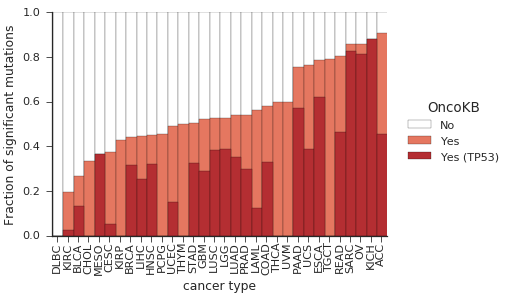

In [12]:
num_oncokb = plot_df.loc[['Yes', 'Yes (TP53)'],:].sum()
num_oncokb_tp53 = plot_df.loc['Yes (TP53)',:]
total = plot_df.sum()
frac_oncokb = num_oncokb / total
frac_oncokb = frac_oncokb.sort_values()
frac_oncokb_tp53 = num_oncokb_tp53 / total
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    # plot the barplot
    one_list = [1 for i in range(len(total))]
    sns.barplot(frac_oncokb.index, one_list, 
                color='white', label='No')
    sns.barplot(frac_oncokb.index, frac_oncokb, 
                color=sns.color_palette("Reds", 3)[1], label='Yes')
    sns.barplot(frac_oncokb.index, frac_oncokb_tp53[frac_oncokb.index], 
                color=sns.color_palette("Reds", 3)[2], label='Yes (TP53)')
    
    # tweak axis
    sns.despine()
    myleg = plt.legend(loc='upper center', title='OncoKB', bbox_to_anchor=(1.2, .65), ncol=1)
    plt.ylabel('Fraction of significant mutations')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    
    # max bars full width
    myax = plt.gca()
    for bar in myax.patches:
        bar.set_width(1)
        
    # save figure
    plt.gcf().set_size_inches(6,4)
    plt.savefig('CHASMplus/figures/figure_S3c_bottom.pdf', bbox_inches='tight', bbox_extra_artists=[myleg])

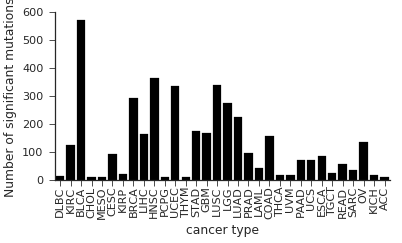

In [13]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    sns.barplot(frac_oncokb.index, total[frac_oncokb.index], color='black')
    
    # tweak formatting
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    sns.despine()
    plt.ylabel('Number of significant mutations')
    
    # save figure
    plt.gcf().set_size_inches(6, 3)
    plt.savefig('CHASMplus/figures/figure_S3_top.pdf')

### Sensitivity comparison with hotspot detection

In [14]:
# merge results of hotspot detection from method by Chang et al.
rename_dict = {'Amino_Acid_Position': 'Protein_position'}
hotspot_df = pd.read_table('CHASMplus/data/misc/hotspot_detection_result.txt').rename(columns=rename_dict)
signif_hotspot_df = hotspot_df[hotspot_df['qvalue']<=0.01]
signif_hotspot_df['Hotspot_flag'] = 1
signif_hotspot_df['Protein_position'] = signif_hotspot_df['Protein_position'].astype(str)  # hack to make it the same dtype

In [15]:
hotspot_cols = ['Hugo_Symbol', 'Protein_position', 'Hotspot_flag']
merged_df2 = pd.merge(merged_df, signif_hotspot_df[hotspot_cols], 
                      on=['Hugo_Symbol', 'Protein_position'], how='left')
merged_df2['Hotspot_flag'] = merged_df2['Hotspot_flag'].fillna(0).astype(int)
merged_df2 = merged_df2.drop_duplicates(subset=['Hugo_Symbol', 'HGVSp_Short'])
merged_df2 = merged_df2[merged_df2['OncoKB_flag']!='No']

In [16]:
grp = merged_df2.groupby('OncoKB_flag')[['Hotspot_flag', 'PANCAN_flag']]
oncokb_overlap = grp.sum()
total_oncokb = merged_df2['OncoKB_flag'].value_counts()
frac_oncokb = oncokb_overlap.div(total_oncokb, axis=0)

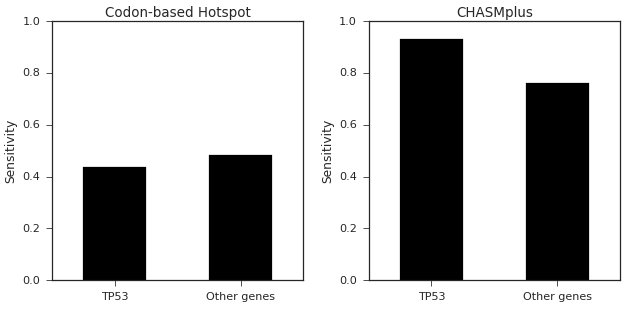

In [20]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches((9,4.5))
    
    # first plot
    ax = axes[0]
    sns.barplot(['TP53', 'Other genes'], frac_oncokb.loc[['Yes (TP53)', 'Yes'], 'Hotspot_flag'], 
                ax=ax, color='black')
    ax.set_ylabel('Sensitivity')
    ax.set_ylim((0, 1))
    ax.set_title('Codon-based Hotspot')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    for i, bar in enumerate(ax.patches):
        bar.set_width(.5)
        bar.set_x(i-.25)
    
    # second plot
    ax = axes[1]
    sns.barplot(['TP53', 'Other genes'], frac_oncokb.loc[['Yes (TP53)', 'Yes'], 'PANCAN_flag'], ax=ax, color='black')
    ax.set_ylabel('Sensitivity')
    ax.set_ylim((0, 1))
    ax.set_title('CHASMplus')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    for i, bar in enumerate(ax.patches):
        bar.set_width(.5)
        bar.set_x(i-.25)
    
    # save plot
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_7b.pdf')

#### Sensitivity test (all oncokb mutations)

In [31]:
tmp_dataframe = merged_df2[['Hotspot_flag', 'PANCAN_flag']]

In [32]:
%%R -i tmp_dataframe
mat <- table(tmp_dataframe$Hotspot_flag, tmp_dataframe$PANCAN_flag)
print(mat)
mcnemar.test(mat)

   
      0   1
  0 129 351
  1  19 397

	McNemar's Chi-squared test with continuity correction

data:  mat
McNemar's chi-squared = 296.11, df = 1, p-value < 2.2e-16



#### Sensitivity test (exclude TP53 mutations)

In [35]:
tmp_dataframe2 = merged_df2[(merged_df2['OncoKB_flag']=='Yes')][['Hotspot_flag', 'PANCAN_flag']]

In [36]:
%%R -i tmp_dataframe2
print(mat)
mat <- table(tmp_dataframe$Hotspot_flag, tmp_dataframe$PANCAN_flag)
mcnemar.test(mat)

   
      0   1
  0 104 157
  1  17 229

	McNemar's Chi-squared test with continuity correction

data:  mat
McNemar's chi-squared = 111.04, df = 1, p-value < 2.2e-16



### Gene heatmap

Examine the most frequent cancer type specific predictions by CHASM2. First, we process the data.

In [37]:
# melt the data frame
cancer_types = [os.path.basename(f)[:-4] for f in glob.glob('{0}/*.txt'.format('CHASMplus/data/aggregated_results/')) if 'PANCAN' not in f]
merged2_df = pd.melt(merged_df, 
                     id_vars=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short'], value_vars=cancer_types+['PANCAN'],
                     var_name='CODE', value_name='qvalue')
merged2_df = merged2_df.dropna()
merged2_df['Protein_position'] = merged_df['HGVSp_Short'].str[3:-1]

# merge with 
mut_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.maf')
mut_df = pd.merge(mut_df, merged2_df, 
                  on=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CODE'],
                  how='left')

We then create a heatmap of the top 25 genes based on driver frequency.

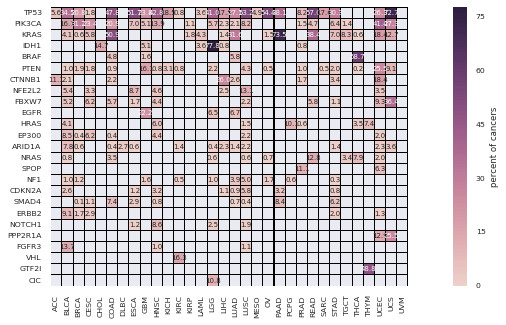

In [44]:
from matplotlib.colors import ListedColormap

# calc mutation frequency
mutated_samps = mut_df[mut_df['qvalue']<=.01].groupby(['CODE', 'Hugo_Symbol'])['Tumor_Sample_Barcode'].nunique()
order = mutated_samps.reset_index(name='number of mutations').groupby('Hugo_Symbol')['number of mutations'].sum().sort_values(ascending=False).index.tolist()[:25]
total_samps = mut_df.groupby('CODE')['Tumor_Sample_Barcode'].nunique()
frac_mutated_samps = (mutated_samps / total_samps).reset_index(name='fraction of samples')

# create heatmap
plot_df_orig = frac_mutated_samps.pivot('CODE', 'Hugo_Symbol', 'fraction of samples')
plot_df = plot_df_orig.fillna(0)
with sns.plotting_context('talk', font_scale=.6), sns.axes_style('darkgrid'):
    cm = sns.heatmap(100*plot_df.loc[:, order].T, 
                     square=True, 
                     linewidth=.01, linecolor='black', fmt='.1f',
                     annot=100*plot_df_orig.loc[:, order].T,
                     annot_kws={'fontsize': 7},
                     mask=plot_df_orig.loc[:, order].T.isnull(),
                     cbar=True,
                     cbar_kws={'label': 'percent of cancers'},
                     cmap = ListedColormap(sns.color_palette(sns.cubehelix_palette(100).as_hex())))

# modify display of plot
plt.ylabel('')
plt.xlabel('')
_ = plt.setp(cm.yaxis.get_majorticklabels(), rotation=0)
_ = plt.setp(cm.xaxis.get_majorticklabels(), rotation=90, ha='center', va='top')

# save figure
plt.gcf().set_size_inches(16, 5)
plt.savefig('CHASMplus/figures/figure_S3d.pdf')